# Introduction and motivation

Gaussian Processes (GPs) are a very useful type of model which has several attractive features. First, GPs offer a method for doing exact inference on non-linear regression problems. Second, model accuracy and complexity are naturally balanced in GPs, preventing overfitting while preserving model capacity. Third, model comparison can be done rigorously by comparing the marginal log-likelihoods of different GPs.

However, the computational complexity of fitting a gaussian process scales as $\mathcal{O}(N^3)$ with the number of datapoints, $N$, because of the inversion of the covariance matrix. For example, the predictive mean and covariance for a GP with kernel $k(\cdot, \cdot)$ and train-data covariance matrix $\mathbf{K}$ are

$$ \begin{align} \mu &=  k(x^* ,\mathbf{x})^\top [\mathbf{K} + \sigma^2_{noise} \mathbf{I}]^{-1} \mathbf{y} \\
\sigma^2 &= k(\mathbf{x}^*, \mathbf{x}^*) + \sigma^2_{noise} + k(x^* ,\mathbf{x})^\top [\mathbf{K} + \sigma^2_{noise} \mathbf{I}]^{-1} k(x^*,\mathbf{x}) \end{align}$$

both of which involve the inversion of an $N\times N$ matrix, corresponding to $\mathcal{O}(N^3)$ complexity. Even worse, learning the hyperparameters of the covariance matrix involves several such $\mathcal{O}(N^3)$ inversions. Therefore, vanilla GPs unwieldy for many datasets of practical interest. Many approximation schemes have been devised to make GPs tractable for large datasets. In this notebook we present an elegant and general variational inference method developed by Michalis Titsias ([paper 2009](http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf)). This is based on using $M < N$ pseudo-points to "approximate" the dataset, allowing learning and prediction in $\mathcal{O}(NM^2)$ time. The positions of the pseudo-points are treated as variational parameters and are opitimised along with the hyperparameters.

We found that the original paper did not mention some important implementation details including the Woodbury Identity and the Matrix Determinant Lemma, which are necessary to achieve $\mathcal{O}(NM^2)$ complexity (possibly assuming these are elemetary and known to the reader). Handling matrix multiplications to avoid $N^2$ or $N^3$ complexity was also non-trivial. We try to highlight such potential pitfalls as well as to make the notebook mathematically self-contained.

# The variational approximation for Sparse Gaussian Processes

In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import pandas as pd

from utils import fast_matrix_det, fast_quadratic_form, woodbury, rbf

DATA_DIR = "../data/sparse/"

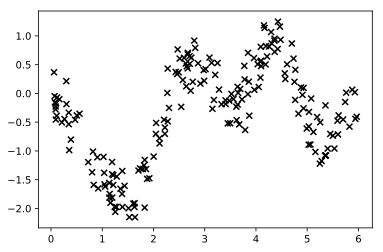

In [2]:
X_n = pd.read_csv(DATA_DIR + '/train_inputs', header=None, sep='\s+').values
Y = pd.read_csv(DATA_DIR + '/train_outputs', header=None, sep='\s+').values

plt.scatter(X_n, Y, marker='x', color='k')
plt.show()

In [3]:
def get_predictive_variational_gp(X_m, X_n, Y, sigma_noise, sigma_f, length_scale):
    """
    """
    n = len(X_n)
    
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    K_mm = K[n:, n:]
    K_nm = K[:n, n:]
    K_mm_inv = np.linalg.inv(K_mm)
    
    Sigma = np.linalg.inv(K_mm + sigma_noise ** -2. * np.dot(K_nm.T, K_nm))
    mu = sigma_noise ** -2. * np.dot(K_mm, np.dot(np.dot(Sigma, K_nm.T), Y.reshape(-1, 1)))
    
    def mu_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_m), axis=0), sigma_f, length_scale)
        K_xm = K_[:1, 1:]
        
        return np.dot(np.dot(K_xm, K_mm_inv), mu)
    
    def cov_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_m), axis=0), sigma_f, length_scale)
        K_xx = K_[:1, :1]
        K_xm = K_[:1, 1:]
        
        return K_xx + sigma_noise ** 2. - np.dot(np.dot(K_xm, K_mm_inv), K_xm.T) \
                + np.dot(np.dot(K_xm, Sigma), K_xm.T)
    
    return mu_fn, cov_fn

In [4]:
def gp_log_prob(X_n, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    
    n = len(X_n)
    
    K = rbf(X_n, sigma_f, length_scale)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)
    
    Sigma = noise_cov + K
    
    det_gp_cov = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    
    log_prob = -n / 2. * np.log(2 * np.pi) \
                -0.5 * np.log(det_gp_cov) \
                -0.5 * np.dot(np.dot(Y.T, Sigma_inv), Y)
    
    if verbose:
        print("\n==================")
        print(det_gp_cov)
        print(log_prob)
        print("\n==================")
    
    return log_prob

In [5]:
def free_energy(X_n, X_m, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    n = len(X_n)
    
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    K_mm = K[n:, n:]
    K_nm = K[:n, n:]
    K_mm_inv = np.linalg.inv(K_mm + 1e-6 * np.eye(K_mm.shape[0]))
    
    noise_cov_diag = (sigma_noise ** 2.) * np.ones(n)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)
    
    gp_cov = np.dot(np.dot(K_nm, K_mm_inv), K_nm.T)
    det_gp_cov_slow = np.linalg.det(noise_cov + gp_cov)
    det_gp_cov = fast_matrix_det(noise_cov_diag, K_nm, K_nm.T, K_mm)
    gp_QF = fast_quadratic_form(noise_cov_diag, K_nm, K_nm.T, K_mm, Y)
    
    log_prob_gaussian = -n / 2. * np.log(2 * np.pi) \
                        -0.5 * np.log(det_gp_cov) \
                        -0.5 * gp_QF
    
    regularising_term = 1. / (2 * sigma_noise ** 2.) * (np.trace(K_nn) - np.trace(gp_cov))
    
    if verbose:
        print("\n==================")
        print(np.linalg.det(noise_cov))
        print(np.linalg.det(K_mm_inv), det_gp_cov)
        print(det_gp_cov_slow)
        print(gp_QF)
        print(regularising_term)
        print(log_prob_gaussian)
        print("\n==================")
        
    return log_prob_gaussian - regularising_term

In [6]:
def fit_sgd(X_n, X_m, Y, log_sigma_noise=1., log_sigma_f=0., log_length_scale=-1., learn_rate=1e-1,
            num_iter=5000, early_stopping=1e-3, verbose=True):
    
    prev = -np.inf
    log_every = 100
    
    F_lambda = lambda X_m_, log_sigma_noise_, log_sigma_f_, log_length_scale_: \
                   free_energy(X_n, X_m_, Y, np.exp(log_sigma_noise_), np.exp(log_sigma_f_), np.exp(log_length_scale_))
    
    theta = [X_m, log_sigma_noise, log_sigma_f, log_length_scale]
    dF_dtheta = [grad(F_lambda, i) for i in range(len(theta))]

    # Keep track of the loss
    prev_F = F_lambda(*theta)
    
    for i in range(num_iter):

        grads = [dF_dtheta[j](*theta) for j in range(len(theta))]
        theta = [theta[j] + learn_rate * gradient / len(Y) for j, gradient in enumerate(grads)]
        
        current_F = F_lambda(*theta)
        
        if abs(prev_F - current_F) <= early_stopping:
            print("Early convergence at iteration {}!".format(i))
            return tuple(theta)
        else:
            prev_F = current_F
            yield tuple(theta)

(10, 1)
Iteration: 0 sigma_noise: 2.482, sigma_f: 0.995, length_scale: 0.369, free_energy: -379.941


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


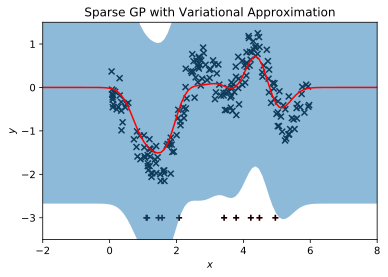

Iteration: 100 sigma_noise: 0.293, sigma_f: 0.714, length_scale: 0.712, free_energy: -65.440


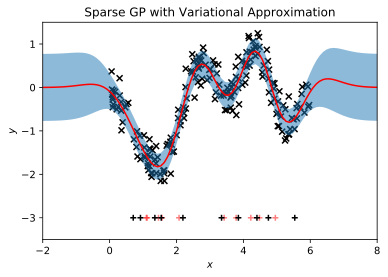

Iteration: 200 sigma_noise: 0.288, sigma_f: 0.818, length_scale: 0.692, free_energy: -60.015


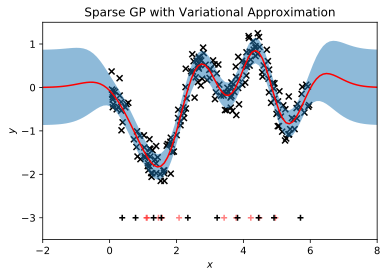

Iteration: 300 sigma_noise: 0.287, sigma_f: 0.848, length_scale: 0.676, free_energy: -58.550


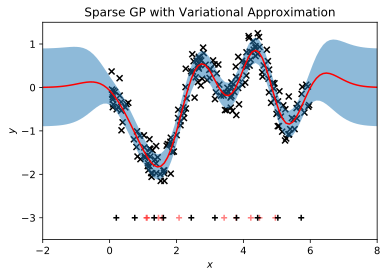

Iteration: 400 sigma_noise: 0.286, sigma_f: 0.855, length_scale: 0.673, free_energy: -58.316


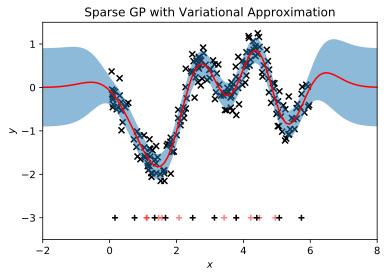

Early convergence at iteration 409!


In [7]:
X_m = np.random.uniform(1., 5., 10).reshape((-1, 1))
X_m_init = X_m.copy()
print(X_m.shape)
Y = Y.squeeze()

for i, (X_m, log_sigma_noise, log_sigma_f, log_length_scale) in enumerate(fit_sgd(X_n, X_m, Y)):
    
    if i % 100 == 0:
        free_en = free_energy(X_n, X_m, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale))
        print('Iteration:', i, 
              'sigma_noise: %.3f, sigma_f: %.3f, length_scale: %.3f, free_energy: %.3f'
               % (np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale), free_en))
        
        mu_fn, cov_fn = get_predictive_variational_gp(X_m, X_n, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f),
                                                      np.exp(log_length_scale))

        xs = np.linspace(-2., 8., 100)
        mus = np.array([mu_fn(x) for x in xs])
        stds = np.array([cov_fn(x)**0.5 for x in xs])

        plt.scatter(X_n, Y, marker='x', color='k')
        plt.scatter(X_m_init, -3 * np.ones_like(X_m_init), marker='+', color='r', alpha=0.5)
        plt.scatter(X_m, -3 * np.ones_like(X_m), marker='+', color='k')
        plt.plot(xs, mus.squeeze(), color='r')
        plt.fill_between(xs, (mus-stds).squeeze(), (mus+stds).squeeze(), alpha=.5)
        plt.title('Sparse GP with Variational Approximation')
        
        plt.xlim([-2., 8.])
        plt.ylim([-3.5, 1.5])
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.show()